In [1]:
import os
import random

import numpy as np

from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

from models import *

In [2]:
plt.rcParams["figure.figsize"] = (15, 20)

In [3]:
# first, read in the nouns
with open("data/2000_nouns_sorted.txt") as reader:
    nouns = reader.read().split("\n")
    # strip whitespace
    nouns = list(map(lambda _:_.strip(), nouns))
nouns[:5]

['dollar', 'formula', 'pound', 'quote', 'ability']

In [4]:
# we load only the embeddings we want, and store them back to reuse
def read_model(model_name):
    pkl_file = "./models/2000_nouns_{}.pkl".format(model_name)
    if not os.path.exists(pkl_file):
        print("Model doesn't exist, creating it")
        word_index, embeddings = read_embedding_file("./data/{}.bz2".format(model_name), selected_words=nouns)
        sim = WordSimilarityModel(word_index, embeddings)
        pkl.dump(sim, open(pkl_file, "wb"))
        return sim
    return pkl.load(open(pkl_file, "rb"))

bow2_sim = read_model("bow2.words")
bow5_sim = read_model("bow5.words")
deps_sim = read_model("deps.words")

all_sim = [bow2_sim, bow5_sim, deps_sim]

In [5]:
bow2_sim.most_similar('night')

['evening',
 'afternoon',
 'weekend',
 'morning',
 'week',
 'hour',
 'meal',
 'breakfast',
 'month',
 'dawn']

In [6]:
def reduce_dim(nouns, model, method):
    np.random.seed(42)
    if method not in {"tsne", "isomap"}: raise ValueError() ;
    
    words, matrix = model.get_word_index_matrix()
        
    if method == "tsne":
        print("Using t-SNE")
        # TSNE can't handle large dimensions, so use PCA to project it to 50-dim space
        print("Projecting to 50-dim space using PCA")
        pca = PCA(n_components=50)
        matrix_transformed = pca.fit_transform(matrix)
        print("\t... done")
        
        print("Performing t-SNE")
        tsne = TSNE(n_components=2)
        matrix_viz = tsne.fit_transform(matrix_transformed)
        print("\t... done")
        
        # TODO down-sample
        plt.scatter(matrix_viz[:, 0], matrix_viz[:, 1], alpha = 0.5, c = 'r')
        return words, matrix_viz
    
    else:
        print("Using Isomap")
        isomap = Isomap(n_neighbors=5, n_components=2)
        matrix_viz = isomap.fit_transform(matrix)
        print("\t... done")
        
        # TODO down-sample
        plt.scatter(matrix_viz[:, 0], matrix_viz[:, 1], c = 'g', alpha = 0.5)
        return words, matrix_viz
        

In [7]:
def plot_word_clusters(words, lowdim, model_name, n_words=250, alpha=0.5, margin=5):
    np.random.seed(42)
    word_idx = list(zip(words, np.arange(len(words))))
    plt.figure(figsize=(20, 20))

    for _ in np.arange(n_words):
        word, idx = random.choice(word_idx)
        x, y = lowdim[idx]
        plt.text(x, y, word, alpha=alpha)


    plt.xlim(lowdim[:, 0].min() - margin, lowdim[:, 0].max() + margin)
    plt.ylim(lowdim[:, 1].min() - margin, lowdim[:, 1].max() + margin)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("plot_{}".format(model_name), dpi=300, format="eps", transparent = True, frameon = False)

Using t-SNE
Projecting to 50-dim space using PCA
	... done
Performing t-SNE
	... done


Text(0.5,1,'t-SNE on BOW-2')

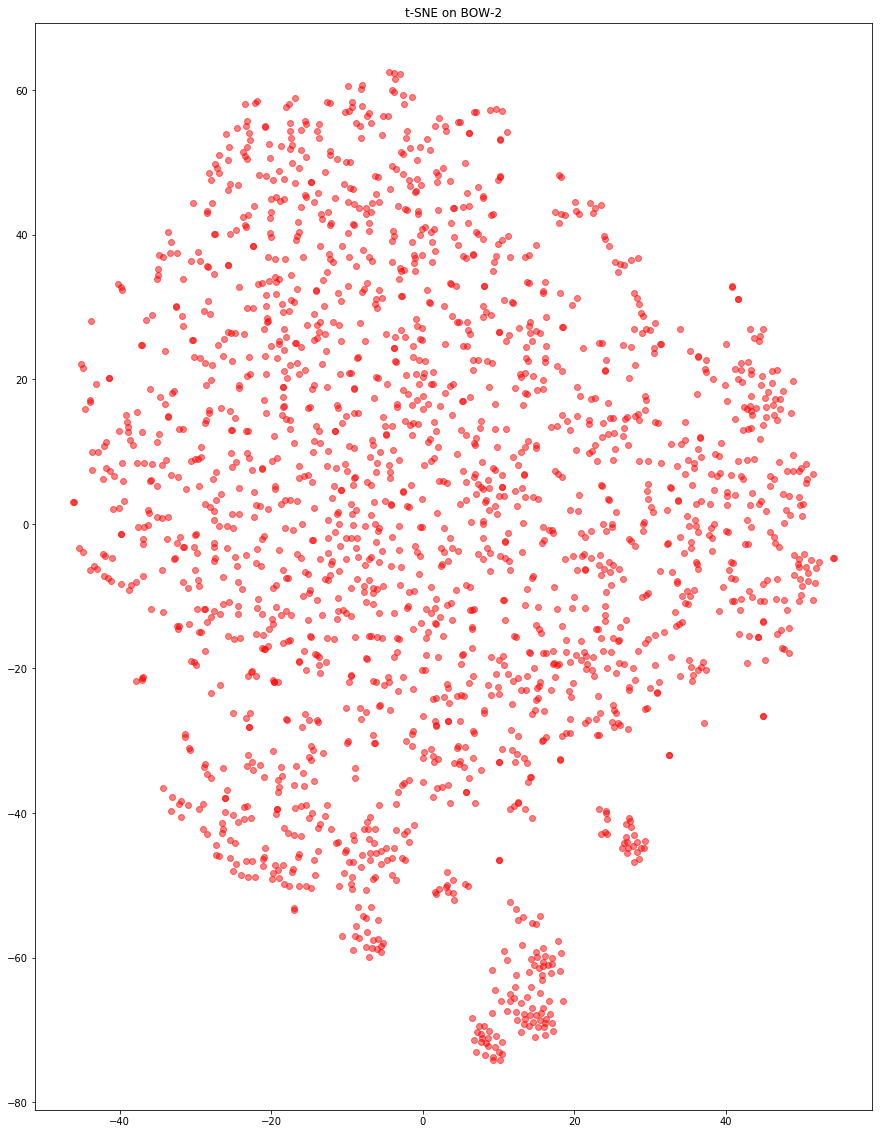

In [8]:
words_tsne, lowdim_tsne = reduce_dim(nouns, bow2_sim, "tsne")
plt.title("t-SNE on BOW-2")

Text(0.5,1,'BOW-2: Word Clusters - 250 words')

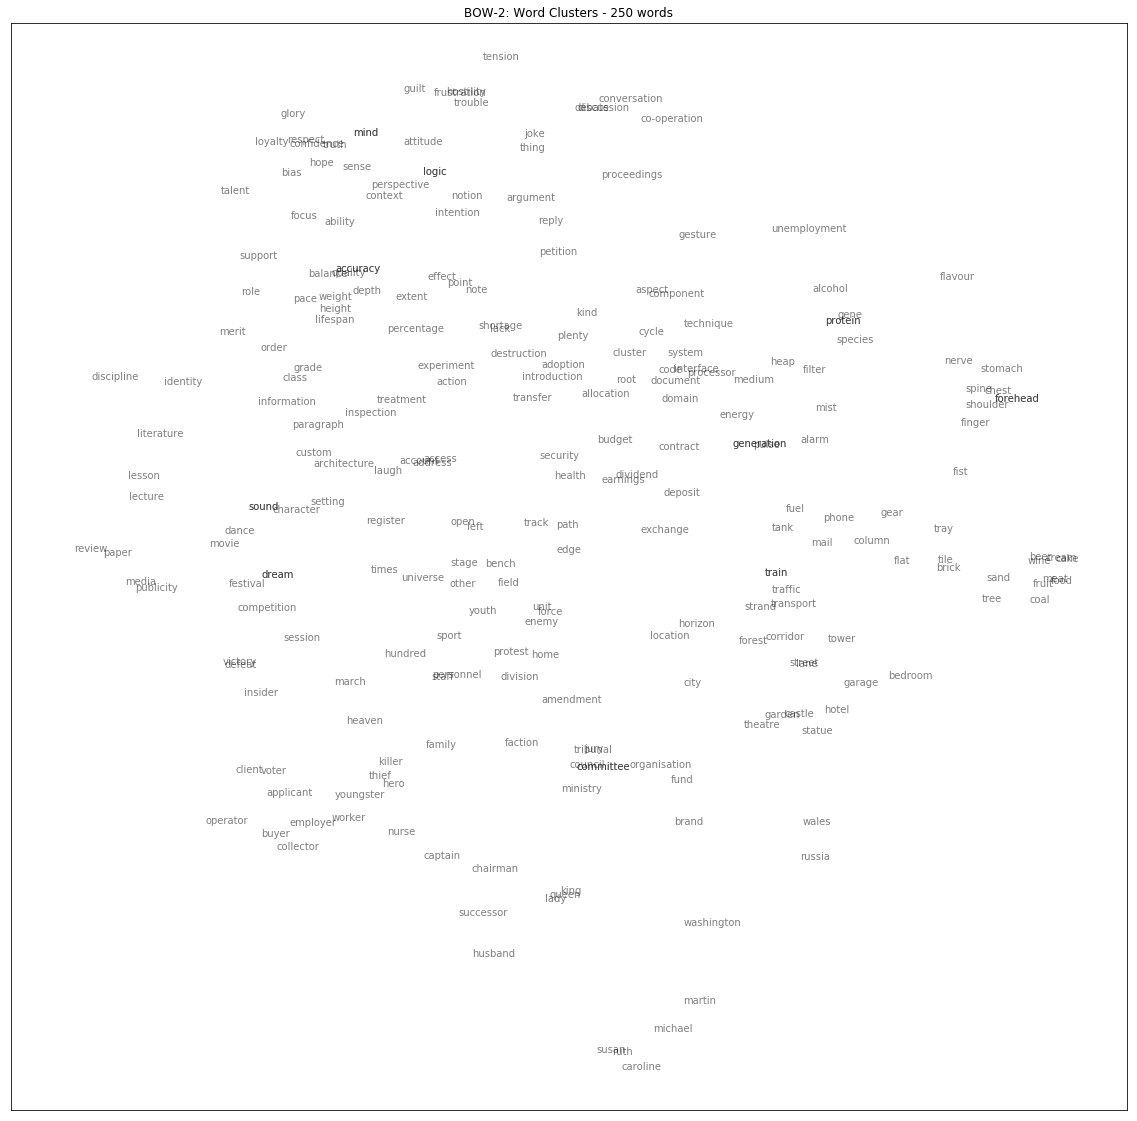

In [9]:
plot_word_clusters(words_tsne, lowdim_tsne, model_name = "Bow2", n_words=250)
plt.title("BOW-2: Word Clusters - 250 words")

Using t-SNE
Projecting to 50-dim space using PCA
	... done
Performing t-SNE
	... done


Text(0.5,1,'t-SNE on BOW-5')

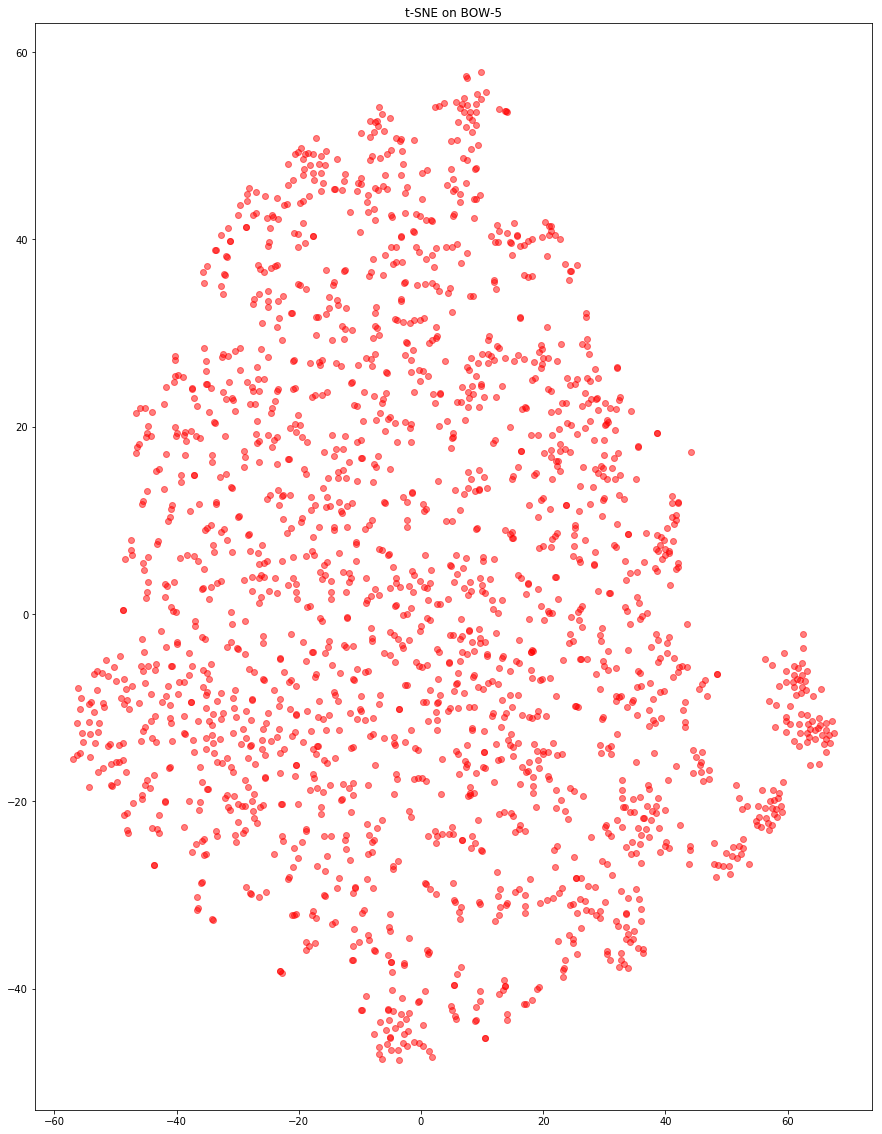

In [10]:
words_tsne, lowdim_tsne = reduce_dim(nouns, bow5_sim, "tsne")
plt.title("t-SNE on BOW-5")

Text(0.5,1,'BOW-5: Word Clusters - 250 words')

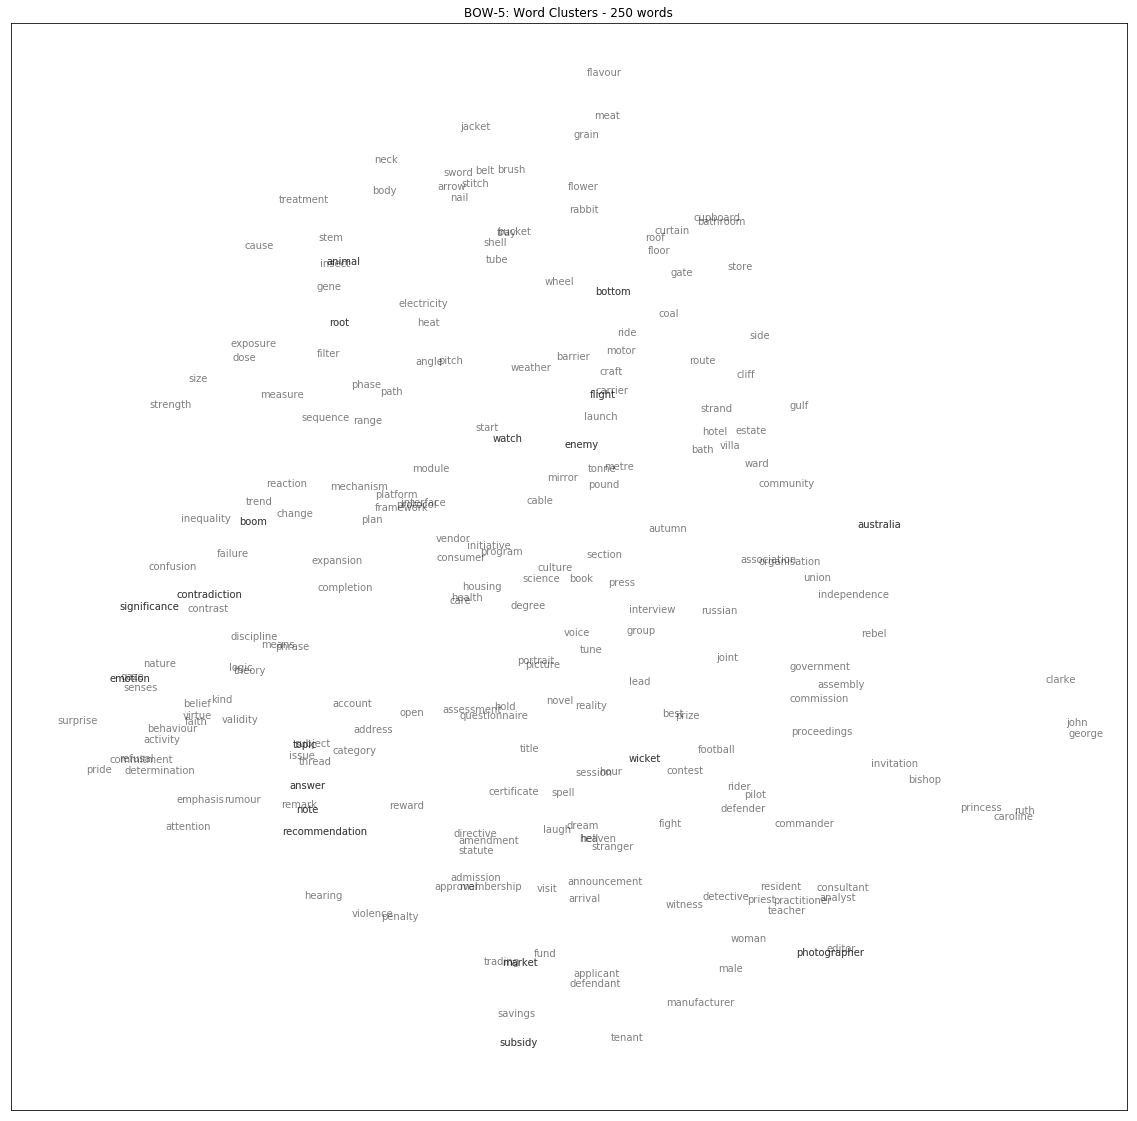

In [11]:
plot_word_clusters(words_tsne, lowdim_tsne, model_name = "Bow5", n_words=250)
plt.title("BOW-5: Word Clusters - 250 words")

Using t-SNE
Projecting to 50-dim space using PCA
	... done
Performing t-SNE
	... done


Text(0.5,1,'t-SNE on Dependencies')

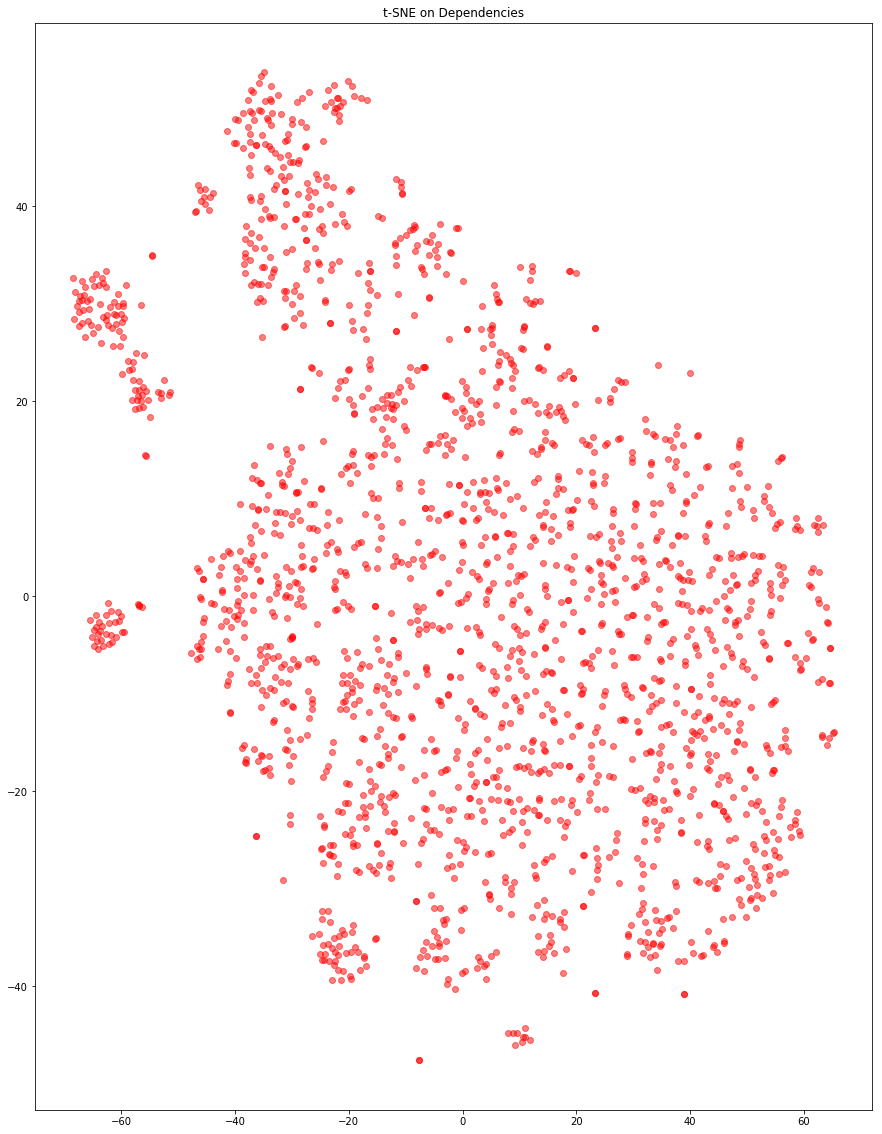

In [12]:
words_tsne, lowdim_tsne = reduce_dim(nouns, deps_sim, "tsne")
plt.title("t-SNE on Dependencies")

Text(0.5,1,'Deps: Word Clusters - 250 words')

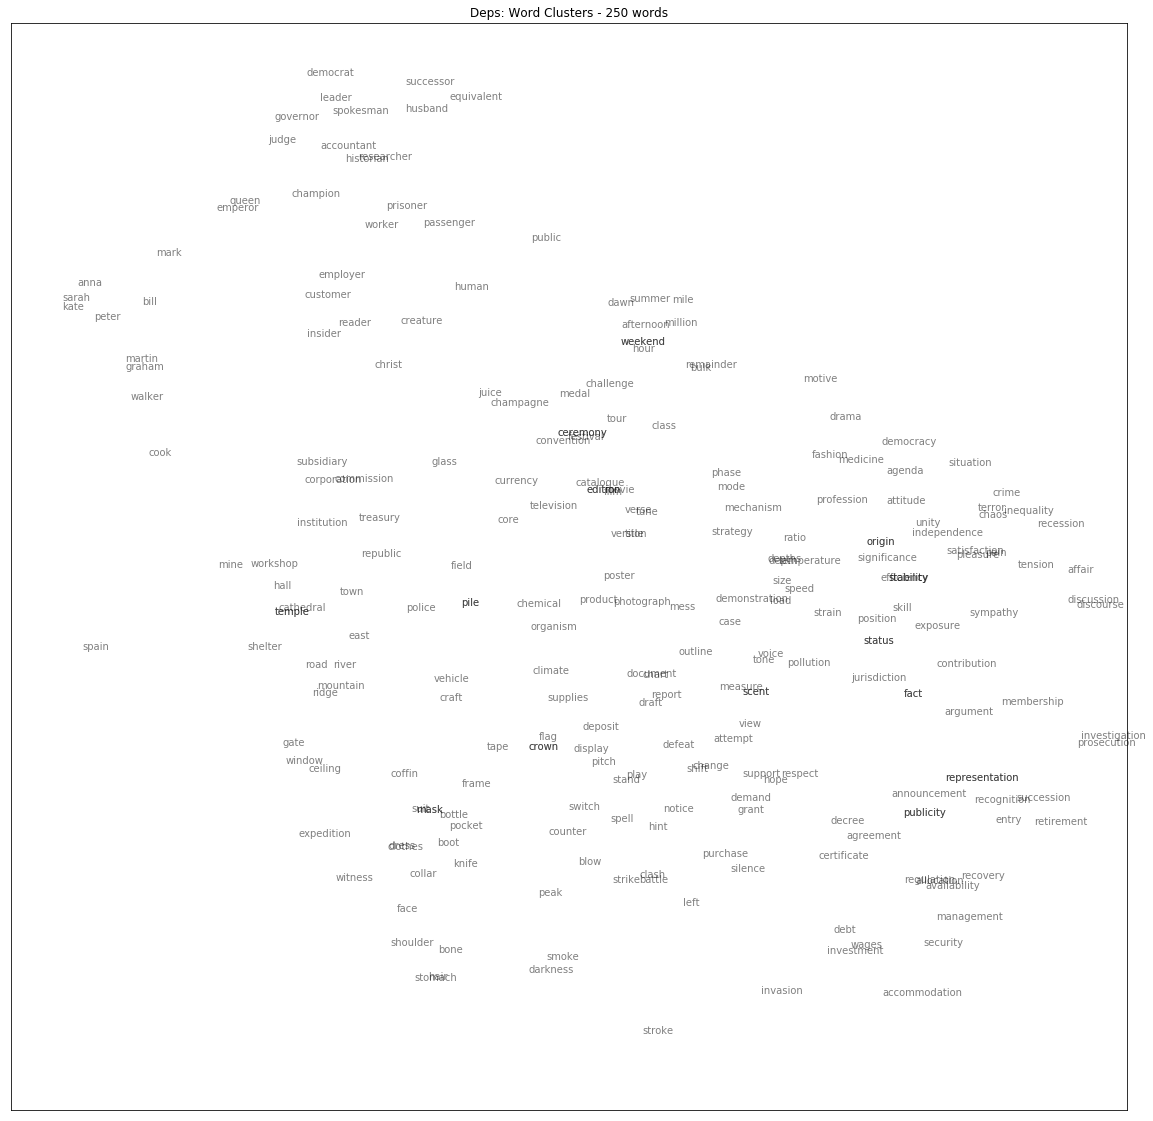

In [13]:
plot_word_clusters(words_tsne, lowdim_tsne, model_name = "Deps", n_words=250)
plt.title("Deps: Word Clusters - 250 words")

## Clustering 

In [14]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [15]:
# TODO: Cite: http://scikit-learn.org/stable/modules/clustering.html
# Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis

In [16]:
def cluster_nouns(model, cluster_space):
    np.random.seed(42)
    words, matrix = model.get_word_index_matrix()
    
    best_score = 0.0
    best_model = 0.0
    
    for cluster in cluster_space:
        print("Trying Cluster Size: {}".format(cluster))
        model = KMeans(n_clusters=cluster, n_init=20, random_state=42, max_iter=1000, n_jobs=-1)
        model.fit(matrix) 
        labels = model.labels_        
        score = metrics.silhouette_score(matrix, labels)
        
        if score > best_score:
            best_score = score
            best_model = model
    
    print("Best score: ", best_score, "\nBest model: ", best_model)
    
    return best_model.predict(matrix)
    

print("Dependency based:")
words, matrix = deps_sim.get_word_index_matrix()
deps_labels = cluster_nouns(deps_sim, [3, 5, 9, 15, 30])

print("\nBoW with k=2:")
words, matrix = bow2_sim.get_word_index_matrix()
bow2_labels = cluster_nouns(bow2_sim, [3, 5, 9, 15, 30, 45, 60])

print("\nBoW with k=5:")
words, matrix = bow5_sim.get_word_index_matrix()
bow5_labels = cluster_nouns(bow5_sim, [3, 5, 9, 15, 30, 45])

Dependency based:
Trying Cluster Size: 3
Trying Cluster Size: 5
Trying Cluster Size: 9
Trying Cluster Size: 15
Trying Cluster Size: 30
Best score:  0.031748855151665006 
Best model:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

BoW with k=2:
Trying Cluster Size: 3
Trying Cluster Size: 5
Trying Cluster Size: 9
Trying Cluster Size: 15
Trying Cluster Size: 30
Trying Cluster Size: 45
Trying Cluster Size: 60
Best score:  0.027271672411460047 
Best model:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=60, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

BoW with k=5:
Trying Cluster Size: 3
Trying Cluster Size: 5
Trying Cluster Size: 9
Trying Cluster Size: 15
Trying Cluster Size: 30
Trying Cluster Size: 45
Best score:  0.03679612822667703 
Best model:  KMeans(algorithm=

In [17]:
def sample_words(cluster_labels, words, n_samples=10):
    np.random.seed(42)
    # convert to numpy array for easier indexing
    words = np.array(words)
    for i in range(cluster_labels.max() + 1):
        print("Sampling from cluster: ", i)
        cluster_words = words[cluster_labels==i]
        if len(cluster_words) <= n_samples:
            choices = cluster_words
        else:
            choices = {random.choice(cluster_words) for _ in range(n_samples)}
        print("\t", end="")
        
        for word in choices:
            print(word, ", ", end="")
            
        print("...\n")

In [18]:
sample_words(bow2_labels, bow2_sim.get_word_index_matrix()[0], n_samples=30)

Sampling from cluster:  0
	apartment , grave , hospital , gallery , home , castle , villa , park , square , lane , camp , farm , tent , station , mill , temple , store , centre , theatre , garage , headquarters , statue , ...

Sampling from cluster:  1
	module , protocol , custom , logic , system , framework , application , processor , design , source , outline , document , model , file , version , software , description , core , index , engine , ...

Sampling from cluster:  2
	desire , pride , soul , fortune , silence , delight , smile , hell , faith , laughter , honour , sleep , friendship , will , kiss , enthusiasm , ambition , self , dream , talent , truth , passion , ...

Sampling from cluster:  3
	film , series , book , play , story , character , episode , novel , movie , scene , figure , drama , theme , plot , chapter , hero , strip , poem , horror , mystery , tale , verse , tune , myth , diary , ...

Sampling from cluster:  4
	tube , pack , metal , blade , wheel , thread , stic

	bread , sugar , beer , sweat , fish , diet , juice , dish , cream , lamb , cattle , potato , crop , champagne , cake , salt , scent , recipe , food , drink , ...

Sampling from cluster:  52
	employer , tenant , employee , competitor , manufacturer , dealer , victim , buyer , viewer , investor , receiver , operator , shareholder , student , parent , owner , customer , patient , offender , public , official , ...

Sampling from cluster:  53
	tendency , activity , nature , reception , prey , female , stance , environment , human , reputation , conduct , role , norm , evolution , behaviour , situation , personality , instinct , animal , ...

Sampling from cluster:  54
	american , english , french , german , russian , secret , peasant , ...

Sampling from cluster:  55
	government , treaty , democracy , election , charter , flag , delegation , declaration , assembly , convention , unity , peace , empire , decree , nation , union , amendment , rule , statute , republic , parliament , ...

Sa

### Qualitative Analysis on BoW, k = 2

- The performance of BoW (k=2) increases linearly with cluster size. Therefore, large (n=60) clusters have a better performance. This is evident if we analyse the clusters thorougly. 

    `Sampling from cluster:  0
	apartment , grave , hospital , gallery , home , castle , villa , park , square , lane , camp , farm , tent , station , mill , temple , store , centre , theatre , garage , headquarters , statue , ...`
    - 0th cluster: The words in this cluster are grouped together on the basis of _forms of buildings_, _places to see/explore_
    
    `Sampling from cluster:  1
	module , protocol , custom , logic , system , framework , application , processor , design , source , outline , document , model , file , version , software , description , core , index , engine , ...`
    - 1st cluster: Words in this cluster are grouped on the basis of _software protocols_
    
    `Sampling from cluster:  12
	guide , science , newspaper , journal , thesis , news , writing , tradition , history , origin , catalogue , library , politics , oxford , painting , landscape , culture , architecture , marx , poetry , university , literature , ...`
    - 12th cluster: Words in this cluster are grouped on the basis of _academia_
    
    `Sampling from cluster:  36
	chair , king , master , captain , manager , prime , prince , head , secretary , cabinet , duke , count , inspector , ambassador , treasury , chief , commander , assistant , chancellor , ministry , emperor , pope , executive , minister , president , ...`
    - 36th cluster: Words in this cluster are grouped on the basis of _people present in a courtroom_
    
    `Sampling from cluster:  51
	bread , sugar , beer , sweat , fish , diet , juice , dish , cream , lamb , cattle , potato , crop , champagne , cake , salt , scent , recipe , food , drink , ...`
    - 51st cluster: Words in this cluster are grouped on the basis of _eatables/food_
    
    ... _so on_
- These are just some examples. However, we can easily observe a trend in the clustering BoW (k=2) embeddings, i.e., each cluster has focused information about the target word.

In [19]:
sample_words(bow5_labels, bow5_sim.get_word_index_matrix()[0], n_samples=30)

Sampling from cluster:  0
	george , johnson , kelly , tony , howard , robyn , thatcher , earl , baker , ford , bell , emily , lily , ruth , joseph , mungo , sarah , simon , morgan , jane , eliot , cook , mark , caroline , ...

Sampling from cluster:  1
	co-operation , progress , guidance , project , identification , delivery , enquiry , implementation , action , advance , education , evaluation , conduct , investigation , administration , survey , service , allocation , development , questionnaire , application , survival , assistance , research , ...

Sampling from cluster:  2
	handle , left , pace , front , lead , walk , boot , look , spot , mouse , counter , trick , disc , receiver , will , menu , opponent , pitch , let , crack , holding , ball , glance , draw , ride , alarm , drop , ...

Sampling from cluster:  3
	module , interface , datum , mechanism , type , effect , direction , angle , interval , path , system , disk , experiment , element , tool , characteristic , method , fra

### Qualitative Analysis on BoW, k = 5

- BoW (k=5) performs better than BoW (k=2). This word embedding model exhibits best performance with a cluster size of 30. 
    
    `Sampling from cluster:  0
	george , johnson , kelly , tony , howard , robyn , thatcher , earl , baker , ford , bell , emily , lily , ruth , joseph , mungo , sarah , simon , morgan , jane , eliot , cook , mark , caroline , ...`
    - 0th cluster: This cluster groups words on the basis of _famous english authors/poets_
    
    `Sampling from cluster:  2
	handle , left , pace , front , lead , walk , boot , look , spot , mouse , counter , trick , disc , receiver , will , menu , opponent , pitch , let , crack , holding , ball , glance , draw , ride , alarm , drop , ...`
    - 2nd cluster: The topics in this cluster sway between _sports_ and _computer_ terminology though majority of the words capture terms involved in sports.
    
    `Sampling from cluster:  3
	module , interface , datum , mechanism , type , effect , direction , angle , interval , path , system , disk , experiment , element , tool , characteristic , method , fragment , envelope , wave , motion , variable , error , impulse , sequence , core , sample , ...`
    - 3rd cluster: The words in this cluster capture topics within the domain of _computers_
    
    `Sampling from cluster:  13
	nurse , lawyer , employee , pupil , reporter , master , servant , accountant , agent , collector , policeman , poet , farmer , teacher , inhabitant , priest , photographer , resident , landlord , hero , architect , journalist , publisher , ...`
    - 13th cluster: The words in this cluster are grouped on the basis of _occupations/specializations_
    
    `Sampling from cluster:  19
	guest , inch , year , class , series , anniversary , million , chart , time , ceremony , place , thousand , june , handful , host , schedule , century , while , march , hour , wicket , holiday , times , week , ...`
    - 19th cluster: While most of the words in this cluster capture the notion of _events/time based events_, some words like 'wicket' and 'guest' deviate from the cluster topic.
    
    `Sampling from cluster:  27
	french , state , region , india , gulf , countryside , paris , england , japan , scotland , embassy , middle , europe , colony , german , russia , nation , germany , ireland , kingdom , israel , africa , republic , ...`
    - 27th cluster: Even though the words in this cluster might appear to be part of the same group (say parent group) like _geographical entities_, on closer inspection one can other observe diverse groups. _french_ and _german_ are languages; _state_, _region_, _gulf_ are territories; _india_, _england_, _germany_ are countries and so on.
    
- It becomes clear from this analysis that on some cases BoW (k=5) captures a broad context of topics. However, most of the time, there exists no distinctive separation between diverse topics within a cluster since their meaning gets often blurred in this model.


In [24]:
sample_words(deps_labels, deps_sim.get_word_index_matrix()[0], n_samples=30)

Sampling from cluster:  0
	thomas , corbett , williams , citizen , clerk , manager , expert , paul , soldier , miller , duke , policeman , poet , hitler , shareholder , white , host , harry , traveller , insider , inhabitant , supporter , chancellor , jesus , rival , photographer , sister , journalist , ...

Sampling from cluster:  1
	nature , criterion , process , ratio , deficit , jurisdiction , technique , myth , tendency , tale , suspicion , management , pressure , pursuit , language , profession , conception , significance , hierarchy , mood , principle , mystery , requirement , statistics , admission , resignation , role , guideline , occupation , ...

Sampling from cluster:  2
	chest , clothes , missile , virus , belt , beer , shaft , stock , body , tonne , flag , clock , crop , soil , mask , hand , glass , acid , shell , deck , menu , pocket , stream , patch , eyebrow , wire , cell , black , horn , ...

Sampling from cluster:  3
	point , video , open , lease , print , reference

### Qualitative Analysis on Dependency based model

- This model performs way better than BoW (k=2) but not as good as BoW (k=5). It produces the best scores with a cluster size (n) of 5.

    `Sampling from cluster:  0
	thomas , corbett , williams , citizen , clerk , manager , expert , paul , soldier , miller , duke , policeman , poet , hitler , shareholder , white , host , harry , traveller , insider , inhabitant , supporter , chancellor , jesus , rival , photographer , sister , journalist , ...`
    - 0th cluster: At first glance these words may seem unrelated sematically, but then on closer inspection we deduce that the sets of words follow a **_person (name) <~> occupation_** relationship
    
    `Sampling from cluster:  2
	chest , clothes , missile , virus , belt , beer , shaft , stock , body , tonne , flag , clock , crop , soil , mask , hand , glass , acid , shell , deck , menu , pocket , stream , patch , eyebrow , wire , cell , black , horn , ...`
    - 2nd cluster: The words in this cluster capture relations that are seperated with the aid of **prepositions** (especially the preposition "of"). For example, _chest **of** clothes_, _tonne **of** soil_, _patch **of** crop_ etc.
    
    `Sampling from cluster:  4
	line , february , class , world , corp , press , london , island , school , million , ceremony , corridor , peace , constitution , thousand , britain , people , database , career , film , scene , service , afternoon , jury , business , italy , album , circle , architecture , literature , ...`
    - 4th cluster: The words in this cluster follow a more **complex hierarchical/inferential** relationship. For example, a _scene_ is part of a _film_; _thousand_ &lt; _million_; _class_ is a part of _school_; _circle_ and _line_ are both concepts in (2D) geometry.    
    
    
- Therefore, in this model contexts are derived based on the syntactic relationship between words. These syntactic contexts yield more focused embeddings, capturing more functional and less topical similarity.